# Putting Everything together

În ultima lecție din această secțiune o să refacem tot codul din secțiunea curentă, însă cu unele modificări. Pentru început o să utilizăm și partea de device agnostic code, prin care setăm device-ul pe care să ruleze codul (GPU dacă avem la dispoziție pentru a face computațiile mai rapide). De asemenea o să facem unele modificări și în ceea ce privește crearea modelului, și anume crearea de parametrii ai modelului. O să structurăm acest notebook pe părți pentru a putea fi ușor diferențiat

## 1. Setting up device agnostic code

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Working on a {device}')

Working on a cpu


## 2. Creating the data

In [3]:
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=-1)

weight = 0.7
bias = 0.3

y = weight * X + bias

train_step = int(0.8 * len(X))
X_train, y_train = X[:train_step], y[:train_step]
X_test, y_test = X[train_step:], y[train_step:]

## 3. Visualize the data

In [4]:
def plot_predictions(
        train_data=X_train,
        train_labels=y_train,
        test_data=X_test,
        test_labels=y_test,
        predictions=None,
        ):
    
    plt.figure(figsize=(10, 6))

    plt.scatter(train_data, train_labels, c='b', s=5, label="Train Data")
    plt.scatter(test_data, test_labels, c='g', s=5, label="Test Data")

    if predictions is not None:
        plt.scatter(predictions, test_labels, c='r', s=5, label="Predictions")

    plt.legend()

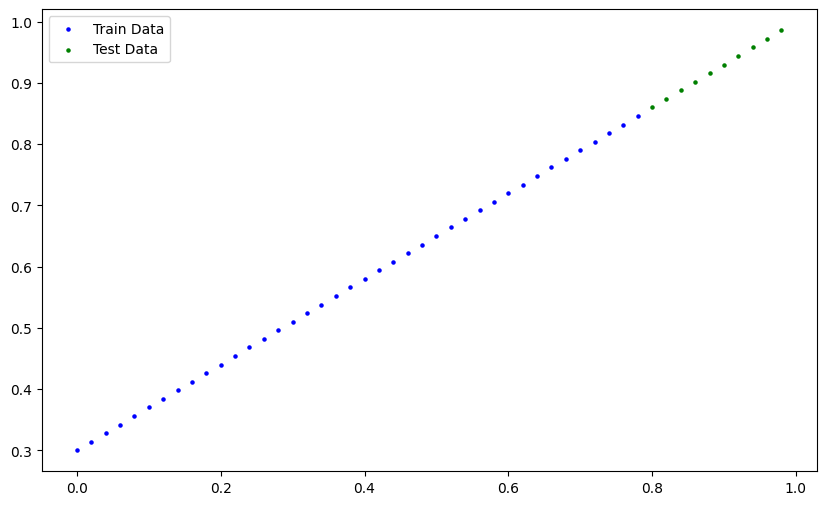

In [5]:
plot_predictions()

## 4. Create a LinearRegressionModel

In [6]:
class LinearRegressionModel(nn.Module):

    def __init__(self):
        super().__init__()

Până în acest moment am creat parametrii modelului manual, utilizând comanda `nn.Parameter()`, dar după cum precizam de cele mai multe ori nu o să trebuiască să creem noi acești parametrii (deoarece nici nu știm exact numărul total de parametrii), o să trebuiască să creem anumite layere în rețeaua neuronală care o să fie între layer-ul de input și layer-ul de ouptut (acestea mai poartă și denumirea de hidden layers). Ceea ce o să creem este un layer liniar (deoarece avem parte de o problemă liniară). Pentru a crea asta o să ne folosim de comanda `nn.Linear()`

In [9]:
class LinearRegressionModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

Codul prin care se creează un layer liniar este cel de sus. Metoda `nn.Linear()` are nevoie de doi parametrii importanți și anume **in_features** și **out_features**. Ce anume reprezintă acești parameterii și de ce am ales valoare 1 pentru aceștia?

Applies a linear transformation to the incoming data: y = weight * x + bias

This module supports TensorFloat32. On certain ROCm devices, when using float16 inputs this module will use different precision for backward.

Parameters:

    - in_features (int) – size of each input sample

    - out_features (int) – size of each output sample

    - bias (bool) – If set to False, the layer will not learn an additive bias. Default: True

Asta este trecut pe site-ul celor de la PyTorch. Acestea sunt informațiile de la `torch.nn.Linear()`. Se poate observa că acest layer aplică o transformare de tipul Linear Regression, tocmai acesta este și motivul pentru care în metoda *forward()* am returnat acuma acest layer, deoarece acesta se ocupă cu partea de computație, de transformare de date. Partea de 'in_features' și 'out_features' face referire la câte features intră în acest layer și câte ies din acesta. În cazul de față intră doar un singur feature (deoarece în cadrul setului de date (X) avem un singur feature), iar ca și output ne interesează să ne returneze tot un singur feature, acel feature care reprezintă defapt estimarea modelului. Pentru a înțelege mai bine cum funcționează asta o să fim nevoiți să lucrăm cu alte seturi de date pentru a putea înțelege.

In [29]:
torch.manual_seed(42)

model_1 = LinearRegressionModel()
model_1.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [30]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

După cum se poate observa, deși am creat un layer liniar doar, acesta ne-a creat automat cei doi parametrii (weight și bias) cu valori stabilite random. Urmează partea de antrenare a modelului

## 5. Train the model

In [47]:
epochs = 200
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.001)

for epoch in range(epochs):
    model_1.train()

    train_preds = model_1(X_train)

    loss = loss_fn(train_preds, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        y_preds = model_1(X_test)

        loss_test = loss_fn(y_preds, y_test)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {loss_test}")

print(model_1.state_dict())   

Epoch: 0 | Train loss: 0.0007765017217025161 | Test loss: 0.0006200253847055137
Epoch: 20 | Train loss: 0.0007765017217025161 | Test loss: 0.0006200253847055137
Epoch: 40 | Train loss: 0.0007765017217025161 | Test loss: 0.0006200253847055137
Epoch: 60 | Train loss: 0.0007765017217025161 | Test loss: 0.0006200253847055137
Epoch: 80 | Train loss: 0.0007765017217025161 | Test loss: 0.0006200253847055137
Epoch: 100 | Train loss: 0.0007765017217025161 | Test loss: 0.0006200253847055137
Epoch: 120 | Train loss: 0.0007765017217025161 | Test loss: 0.0006200253847055137
Epoch: 140 | Train loss: 0.0007765017217025161 | Test loss: 0.0006200253847055137
Epoch: 160 | Train loss: 0.0007765017217025161 | Test loss: 0.0006200253847055137
Epoch: 180 | Train loss: 0.0007765017217025161 | Test loss: 0.0006200253847055137
OrderedDict([('linear_layer.weight', tensor([[0.6999]])), ('linear_layer.bias', tensor([0.3008]))])


## 6. Making predictions with the model

In [48]:
with torch.inference_mode():
    y_preds_new = model_1(X_test)

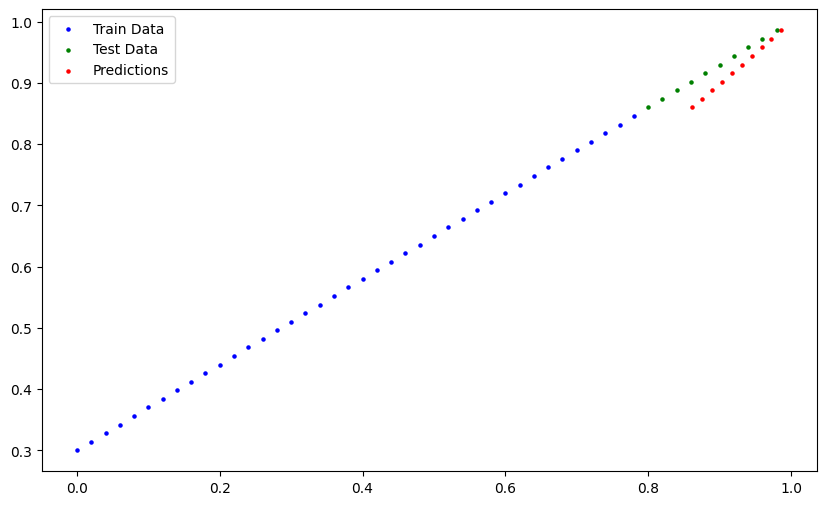

In [49]:
plot_predictions(predictions=y_preds_new)

## 7. Saving and loading the model

In [46]:
torch.save(model_1.state_dict, './models/01_PyTorch_Workflow_model_02.pth')